Get and normalize data

In [71]:
from sklearn.preprocessing import StandardScaler
import random
import numpy as np

file_name = 'who.csv'
data = pd.read_csv(file_name)


columns_of_interest = [
    'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles', 
    'BMI', 'under-five deaths', 'Polio', 'Total expenditure', 'Diphtheria', 
    'HIV/AIDS', 'GDP', 'Life expectancy'
]

data = data[columns_of_interest]
data = data.dropna()

input = data.drop('Life expectancy', axis=1)
output = data['Life expectancy']   

scaler = StandardScaler()
input = pd.DataFrame(scaler.fit_transform(input), columns=input.columns)

print(data.head())
print(input.head())
print(output.head())


   infant deaths  Alcohol  percentage expenditure  Hepatitis B  Measles   BMI  \
0             62     0.01               71.279624         65.0     1154  19.1   
1             64     0.01               73.523582         62.0      492  18.6   
2             66     0.01               73.219243         64.0      430  18.1   
3             69     0.01               78.184215         67.0     2787  17.6   
4             71     0.01                7.097109         68.0     3013  17.2   

   under-five deaths  Polio  Total expenditure  Diphtheria  HIV/AIDS  \
0                 83    6.0               8.16        65.0       0.1   
1                 86   58.0               8.18        62.0       0.1   
2                 89   62.0               8.13        64.0       0.1   
3                 93   67.0               8.52        67.0       0.1   
4                 97   68.0               7.87        68.0       0.1   

          GDP  Life expectancy  
0  584.259210             65.0  
1  612.696514 

In [84]:
def split_train_test(feature_data, output, training_partition):
    """
    Splits the given data into random test and training sets of specified relative sizes

    Parameters:
    - feature_data (np.array): the design matrix containing all data
    - training_partition (float): the relative size of the training datapoints

    Returns:
    - tuple: the randomized and separated training and test inputs and outputs
    """
    feature_data = np.array(feature_data)
    output = np.array(output)
    # print(input)
    # Randomize indices to shuffle the inputs and outputs
    shuffle_indices = np.arange(len(feature_data[0]))
    random.shuffle(shuffle_indices)
    
    # Randomize the order of the input and output data using the indeces above (input transposed to keep data consistent)
    input_data = feature_data.T[shuffle_indices]
    output_data = output[shuffle_indices]

    # Calculate the relative size of the training set and apply it to the input and output data
    split = int(len(input_data)*training_partition)

    training_inputs = input_data[:split]
    training_outputs = output_data[:split]
    test_inputs = input_data[split:]
    test_outputs = output_data[split:]

    return training_inputs, training_outputs, test_inputs, test_outputs

# print(data[columns_of_interest])

train_in, train_out, test_in, test_out = split_train_test(data[columns_of_interest].T, data["Life expectancy"], .8)

print(train_in.shape)
print(test_in.shape)
print(train_in)

(926, 13)
(927, 13)
[[0.00000000e+00 8.95000000e+00 2.55227711e+01 ... 1.00000000e-01
  1.65732280e+03 7.44000000e+01]
 [7.80000000e+01 1.20000000e+00 5.85964449e+01 ... 1.63000000e+01
  3.85756714e+02 5.12000000e+01]
 [2.00000000e+00 2.40000000e-01 6.99675435e+01 ... 1.00000000e-01
  6.21933720e+02 6.00000000e+01]
 ...
 [7.10000000e+01 1.00000000e-02 9.07614441e+01 ... 4.00000000e+00
  6.62492293e+02 6.70000000e+01]
 [1.00000000e+00 3.91000000e+00 2.95608714e+02 ... 1.00000000e-01
  3.99471236e+03 7.46000000e+01]
 [3.00000000e+00 5.79000000e+00 4.72193283e+02 ... 1.00000000e-01
  3.98811894e+03 7.34000000e+01]]


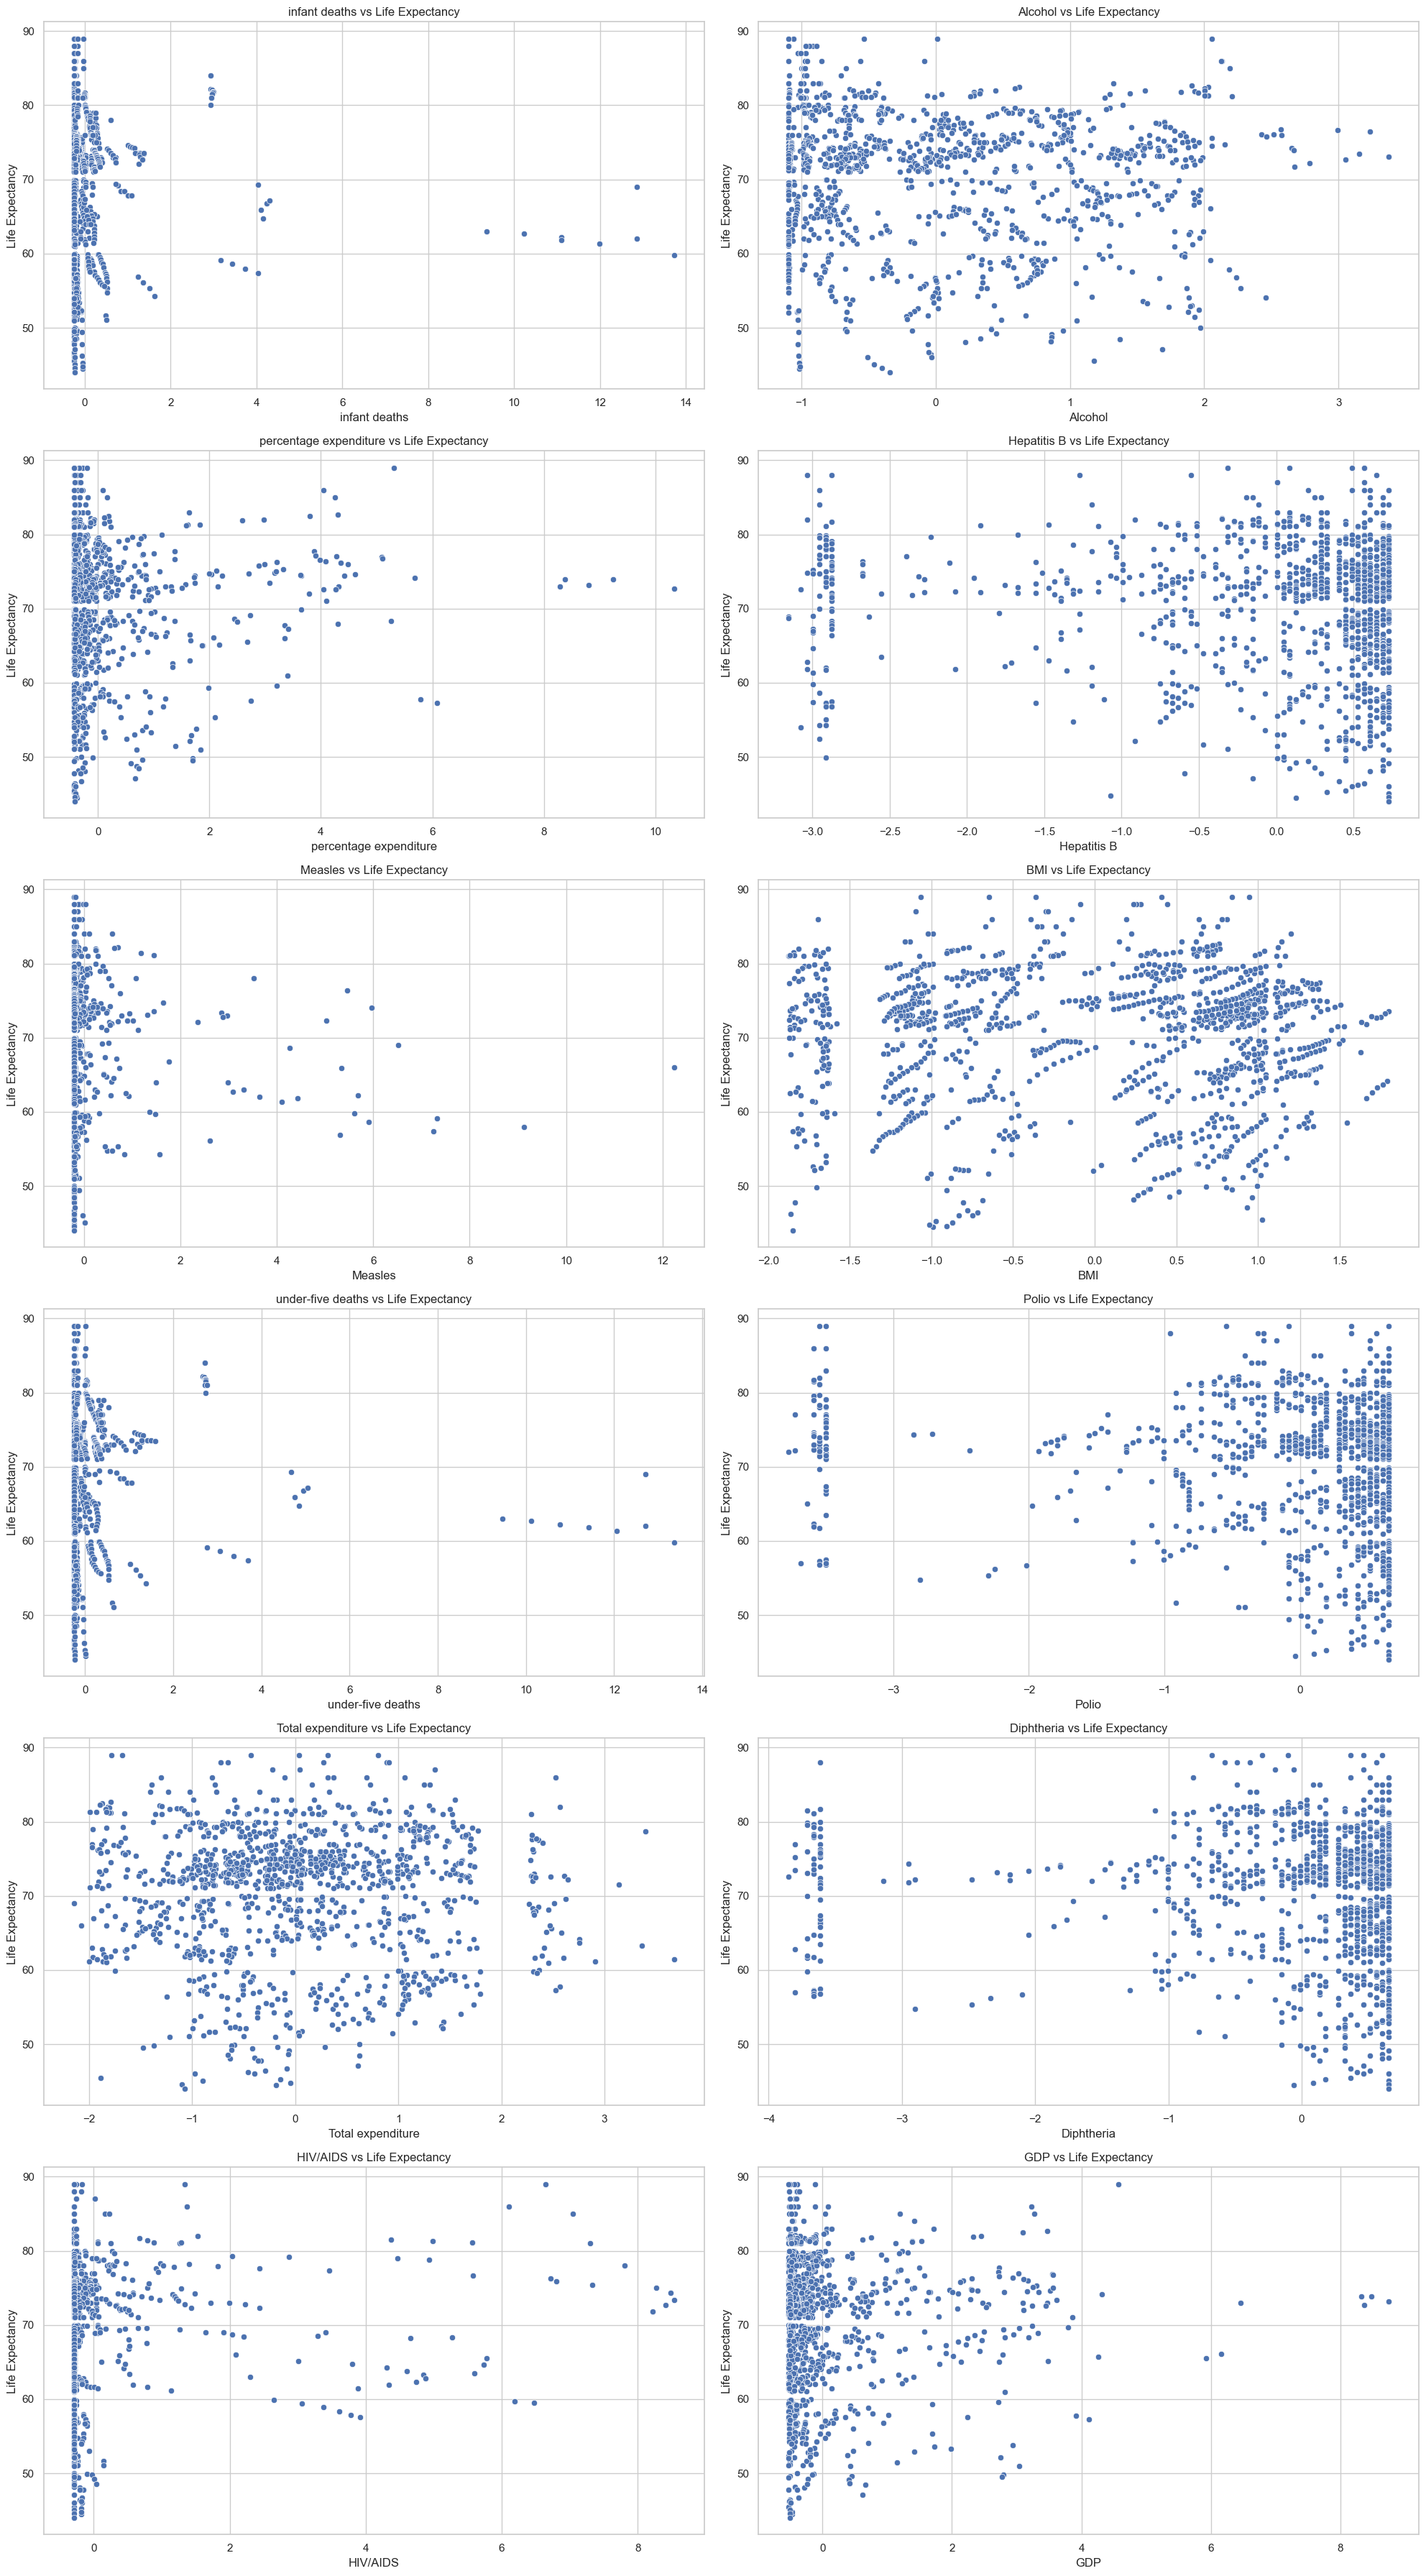

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Determine the number of rows/columns for the subplots
n_columns = len(input.columns)
n_rows = n_columns // 2 + (n_columns % 2)

# Set the size of the overall figure
plt.figure(figsize=(20, 6 * n_rows))

for i, column in enumerate(input.columns):
    # Create a subplot for each column
    plt.subplot(n_rows, 2, i + 1)
    sns.scatterplot(x=input[column], y=output)
    plt.title(f'{column} vs Life Expectancy')
    plt.xlabel(column)
    plt.ylabel('Life Expectancy')

# Adjust layout and display the plot
plt.tight_layout()
plt.savefig('prelim_data_vs.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
useful_columns = [
    'Hepatitis B', 'Polio', 'Total expenditure', 'Schooling', 'BMI', 'Life expectancy '
]

input = input[columns_of_interest]
input

Aryan's Neural Network

Adam's Regression

In [ ]:
# plt.scatter(input["BMI"], output)
# plt.show()
reg_BMI_GDP = LinearRegression().fit(input, output)
reg_BMI_GDP


In [ ]:
def split_train_test(feature_data, output, training_partition):
    """
    Splits the given data into random test and training sets of specified relative sizes

    Parameters:
    - feature_data (np.array): the design matrix containing all data
    - training_partition (float): the relative size of the training datapoints

    Returns:
    - tuple: the randomized and separated training and test inputs and outputs
    """

    # Randomize indices to shuffle the inputs and outputs
    shuffle_indices = np.arange(len(feature_data[0]))
    random.shuffle(shuffle_indices)
    
    # Randomize the order of the input and output data using the indeces above (input transposed to keep data consistent)
    input_data = feature_data.T[shuffle_indices]
    output_data = output[shuffle_indices]

    # Calculate the relative size of the training set and apply it to the input and output data
    split = int(len(input_data)*training_partition)

    training_inputs = input_data[:split]
    training_outputs = output_data[:split]
    test_inputs = input_data[split:]
    test_outputs = output_data[split:]

    return training_inputs, training_outputs, test_inputs, test_outputs

train_in, train_out, test_in, test_out = split_train_test()

TypeError: split_train_test() missing 3 required positional arguments: 'feature_data', 'output', and 'training_partition'

In [ ]:
print()